In [21]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt

entity = "18920011663-king-s-college-london"
project = "World_Model_Curriculum_Learning"          
prefixes = ["CL_WM_without_editing", "CL_WM_without_RB", "CL_WM*"]           
# Define the keys for the data you want to extract
step_key = "curriculum_step"
metric_name = "final_task_performance"
api = wandb.Api(timeout=60)
runs = api.runs(f"{entity}/{project}")
step_min, step_max = 0, 50  # Step range to display


Group 'CL_WM_without_editing': Found 3 runs
  Loaded CL_WM_without_editing_2
  Loaded CL_WM_without_editing_1
  Loaded CL_WM_without_editing

Group 'CL_WM_without_RB': Found 3 runs
  Loaded CL_WM_without_RB_2
  Loaded CL_WM_without_RB_1
  Loaded CL_WM_without_RB

Group 'CL_WM*': Found 3 runs
  Loaded CL_WM*_1
  Loaded CL_WM*_2
  Loaded CL_WM*


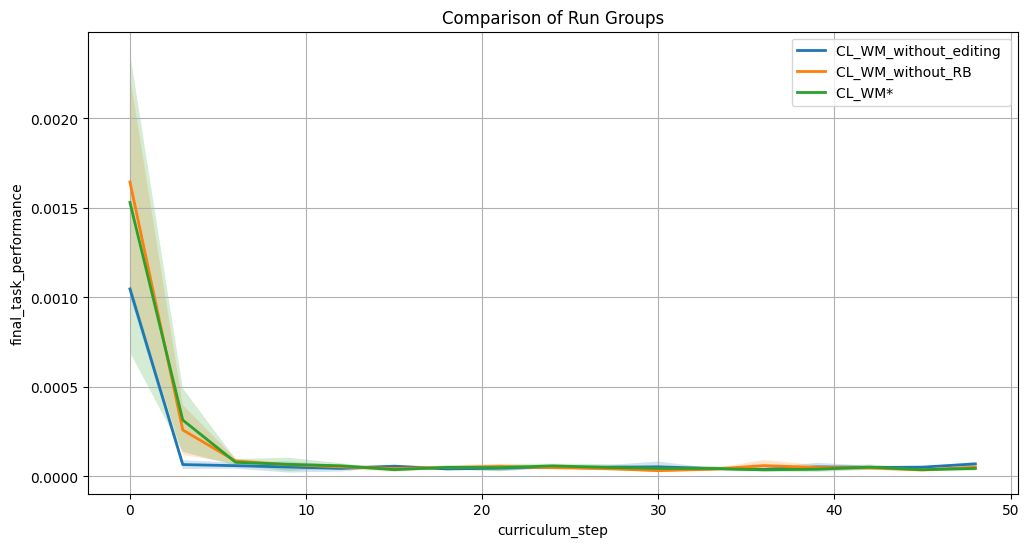

In [22]:
def load_group(prefix):
    runs = api.runs(f"{entity}/{project}")
    selected_runs = [run for run in runs if run.name.startswith(prefix)]
    print(f"\nGroup '{prefix}': Found {len(selected_runs)} runs")

    data_frames = []
    for run in selected_runs:
        try:
            history = run.history()
            if metric_name not in history.columns or step_key not in history.columns:
                print(f"Skipping {run.name}: missing '{metric_name}' or '{step_key}'")
                continue
            df = history[[step_key, metric_name]].dropna()
            df = df.groupby(step_key).mean().reset_index()
            df.rename(columns={metric_name: run.name}, inplace=True)
            data_frames.append(df.set_index(step_key))
            print(f"  Loaded {run.name}")
        except Exception as e:
            print(f"  Error loading {run.name}: {e}")

    if not data_frames:
        return None, None, None
    
    merged_df = pd.concat(data_frames, axis=1)
    mean = merged_df.mean(axis=1)
    std = merged_df.std(axis=1)

    return merged_df.index, mean, std

plt.figure(figsize=(12, 6))

for prefix in prefixes:
    steps, mean, std = load_group(prefix)
    if steps is None:
        continue
    
    # Filter to only include step range 0 to 50
    step_mask = (steps >= step_min) & (steps <= step_max)
    steps_filtered = steps[step_mask]
    mean_filtered = mean[step_mask]
    std_filtered = std[step_mask]
    
    plt.plot(steps_filtered, mean_filtered, linewidth=2, label=f"{prefix} ")
    plt.fill_between(steps_filtered, mean_filtered - std_filtered, mean_filtered + std_filtered, alpha=0.2)

plt.xlabel(step_key)
plt.ylabel(metric_name)
plt.title(f"Comparison of Run Groups")
plt.legend()
plt.grid(True)
plt.show()

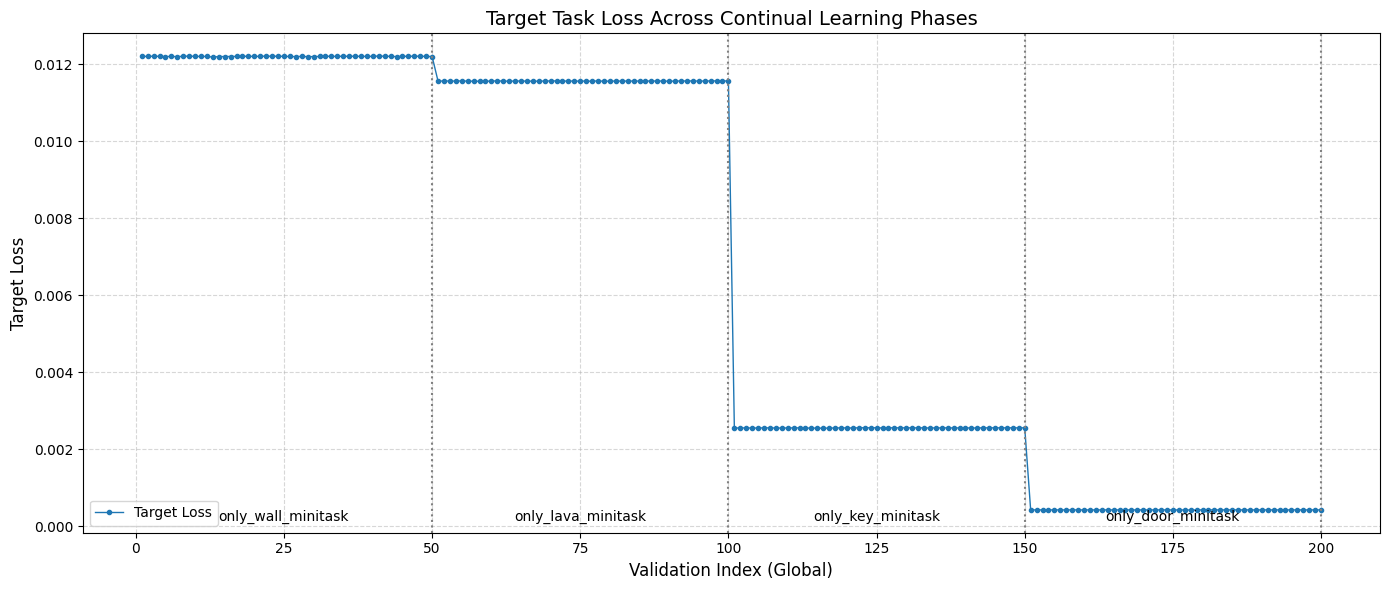

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load CSV
csv_path = "logs/target_eval_log.csv"  # Adjust if necessary
df = pd.read_csv(csv_path)

# Create a continuous index for x-axis
df['global_index'] = range(1, len(df) + 1)

# Create plot
plt.figure(figsize=(14, 6))
plt.plot(df['global_index'], df['target_loss'], marker='o', markersize=3, linewidth=1, label='Target Loss')

# Identify phase boundaries and centers
unique_phases = df['phase'].unique()
phase_centers = []

for phase in unique_phases:
    phase_data = df[df['phase'] == phase]
    start_idx = phase_data['global_index'].min()
    end_idx = phase_data['global_index'].max()
    phase_centers.append((start_idx + end_idx) // 2)
    # Draw boundary line at end of each phase
    plt.axvline(x=end_idx, linestyle='dotted', color='gray')

# Place labels at the bottom
min_loss = df['target_loss'].min()
y_text = min_loss * 0.995  # slightly below the minimum loss on the plot

for center, phase in zip(phase_centers, unique_phases):
    plt.text(center, y_text, phase, rotation=0, ha='center', va='top', fontsize=10)

# Styling
plt.title('Target Task Loss Across Continual Learning Phases', fontsize=14)
plt.xlabel('Validation Index (Global)', fontsize=12)
plt.ylabel('Target Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


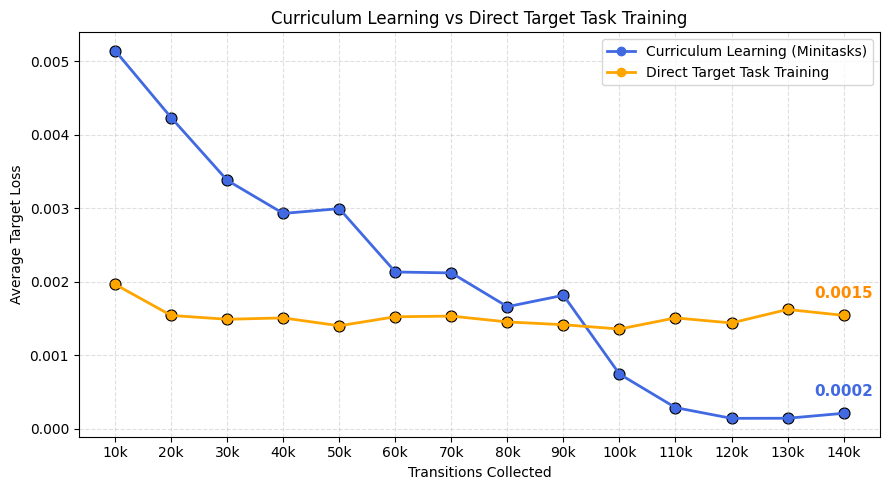

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# === 1. Load data ===
csv_path = "/home/siyao/phd_file/Research/rlPractice/MiniGrid/trainer/logs/target_eval_log_compare_uniform.csv"
df = pd.read_csv(csv_path, header=None)
df.columns = ["seed", "mode", "phase", "transitions", "avg_target_loss"]

# Ensure numeric
df["transitions"] = pd.to_numeric(df["transitions"], errors="coerce")
df["avg_target_loss"] = pd.to_numeric(df["avg_target_loss"], errors="coerce")

# === 2. Split by order (first half = CL, second half = target task) ===
num_per_group = len(df) // 2
cl_df = df.iloc[:num_per_group]
target_df = df.iloc[num_per_group:]

# === 3. X-axis based on cumulative transitions ===
x = cl_df["transitions"].cumsum()
x_target = target_df["transitions"].cumsum()

# === 4. Plot ===
plt.figure(figsize=(9, 5))

# Curriculum Learning line
plt.plot(x, cl_df["avg_target_loss"], marker="o", color="royalblue",
         linewidth=2, label="Curriculum Learning (Minitasks)")
plt.scatter(x, cl_df["avg_target_loss"], color="royalblue", s=60, edgecolor="black")

# Target Task line
plt.plot(x_target, target_df["avg_target_loss"], marker="o", color="orange",
         linewidth=2, label="Direct Target Task Training")
plt.scatter(x_target, target_df["avg_target_loss"], color="orange", s=60, edgecolor="black")

# === 5. Annotate last values ABOVE the points ===
# Curriculum Learning
last_x_cl = x.iloc[-1]
last_y_cl = cl_df["avg_target_loss"].iloc[-1]
plt.text(last_x_cl, last_y_cl + 0.0002, f"{last_y_cl:.4f}", color="royalblue",
         fontsize=11, fontweight="bold", ha="center", va="bottom")

# Target Task
last_x_t = x_target.iloc[-1]
last_y_t = target_df["avg_target_loss"].iloc[-1]
plt.text(last_x_t, last_y_t + 0.0002, f"{last_y_t:.4f}", color="darkorange",
         fontsize=11, fontweight="bold", ha="center", va="bottom")

# === 6. Formatting ===
plt.xlabel("Transitions Collected")
plt.ylabel("Average Target Loss")
plt.title("Curriculum Learning vs Direct Target Task Training")
plt.xticks(x, [f"{int(v/1000)}k" for v in x], rotation=0)
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


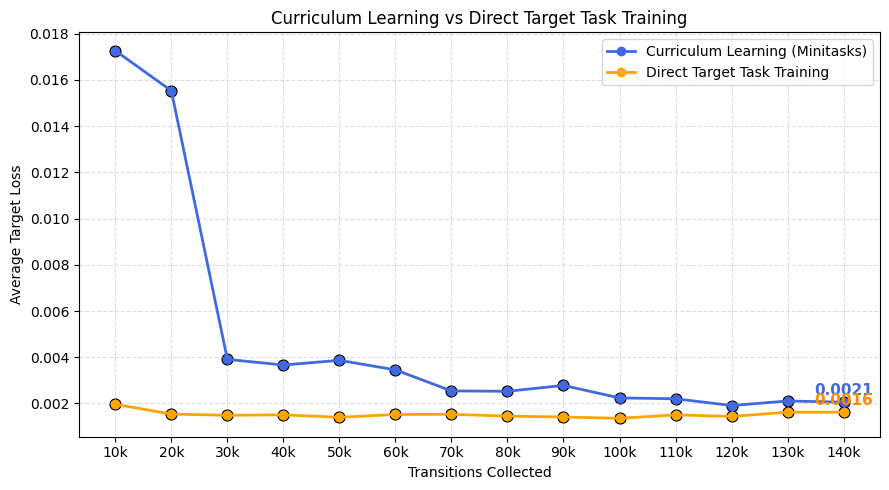

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# === 1. Load data ===
csv_path = "/home/siyao/phd_file/Research/rlPractice/MiniGrid/trainer/logs/target_eval_log_compare_random.csv"
df = pd.read_csv(csv_path, header=None)
df.columns = ["seed", "mode", "phase", "transitions", "avg_target_loss"]

# Ensure numeric
df["transitions"] = pd.to_numeric(df["transitions"], errors="coerce")
df["avg_target_loss"] = pd.to_numeric(df["avg_target_loss"], errors="coerce")

# === 2. Split by order (first half = CL, second half = target task) ===
num_per_group = len(df) // 2
cl_df = df.iloc[:num_per_group]
target_df = df.iloc[num_per_group:]

# === 3. X-axis based on cumulative transitions ===
x = cl_df["transitions"].cumsum()
x_target = target_df["transitions"].cumsum()

# === 4. Plot ===
plt.figure(figsize=(9, 5))

# Curriculum Learning line
plt.plot(x, cl_df["avg_target_loss"], marker="o", color="royalblue",
         linewidth=2, label="Curriculum Learning (Minitasks)")
plt.scatter(x, cl_df["avg_target_loss"], color="royalblue", s=60, edgecolor="black")

# Target Task line
plt.plot(x_target, target_df["avg_target_loss"], marker="o", color="orange",
         linewidth=2, label="Direct Target Task Training")
plt.scatter(x_target, target_df["avg_target_loss"], color="orange", s=60, edgecolor="black")

# === 5. Annotate last values ABOVE the points ===
# Curriculum Learning
last_x_cl = x.iloc[-1]
last_y_cl = cl_df["avg_target_loss"].iloc[-1]
plt.text(last_x_cl, last_y_cl + 0.0002, f"{last_y_cl:.4f}", color="royalblue",
         fontsize=11, fontweight="bold", ha="center", va="bottom")

# Target Task
last_x_t = x_target.iloc[-1]
last_y_t = target_df["avg_target_loss"].iloc[-1]
plt.text(last_x_t, last_y_t + 0.0002, f"{last_y_t:.4f}", color="darkorange",
         fontsize=11, fontweight="bold", ha="center", va="bottom")

# === 6. Formatting ===
plt.xlabel("Transitions Collected")
plt.ylabel("Average Target Loss")
plt.title("Curriculum Learning vs Direct Target Task Training")
plt.xticks(x, [f"{int(v/1000)}k" for v in x], rotation=0)
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()



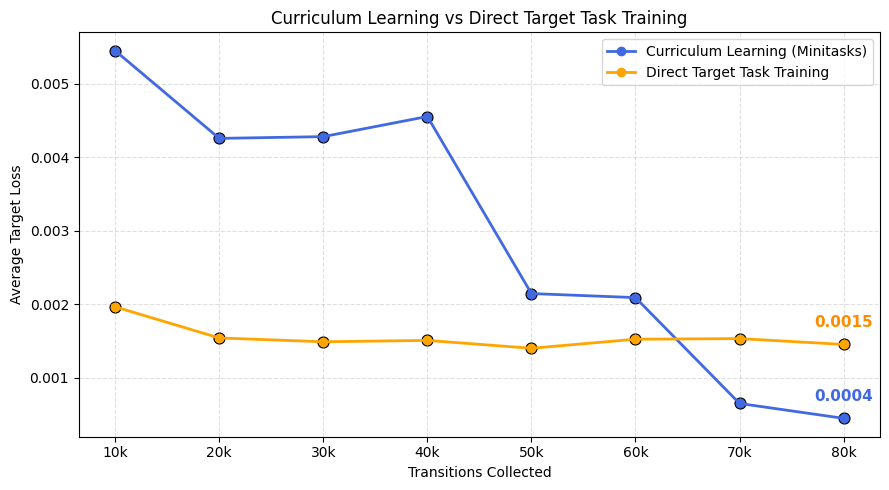

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# === 1. Load data ===
csv_path = "/home/siyao/phd_file/Research/rlPractice/MiniGrid/trainer/logs/target_eval_log_compare_one_element.csv"
df = pd.read_csv(csv_path, header=None)
df.columns = ["seed", "mode", "phase", "transitions", "avg_target_loss"]

# Ensure numeric
df["transitions"] = pd.to_numeric(df["transitions"], errors="coerce")
df["avg_target_loss"] = pd.to_numeric(df["avg_target_loss"], errors="coerce")

# === 2. Split by order (first half = CL, second half = target task) ===
num_per_group = len(df) // 2
cl_df = df.iloc[:num_per_group]
target_df = df.iloc[num_per_group:]

# === 3. X-axis based on cumulative transitions ===
x = cl_df["transitions"].cumsum()
x_target = target_df["transitions"].cumsum()

# === 4. Plot ===
plt.figure(figsize=(9, 5))

# Curriculum Learning line
plt.plot(x, cl_df["avg_target_loss"], marker="o", color="royalblue",
         linewidth=2, label="Curriculum Learning (Minitasks)")
plt.scatter(x, cl_df["avg_target_loss"], color="royalblue", s=60, edgecolor="black")

# Target Task line
plt.plot(x_target, target_df["avg_target_loss"], marker="o", color="orange",
         linewidth=2, label="Direct Target Task Training")
plt.scatter(x_target, target_df["avg_target_loss"], color="orange", s=60, edgecolor="black")

# === 5. Annotate last values ABOVE the points ===
# Curriculum Learning
last_x_cl = x.iloc[-1]
last_y_cl = cl_df["avg_target_loss"].iloc[-1]
plt.text(last_x_cl, last_y_cl + 0.0002, f"{last_y_cl:.4f}", color="royalblue",
         fontsize=11, fontweight="bold", ha="center", va="bottom")

# Target Task
last_x_t = x_target.iloc[-1]
last_y_t = target_df["avg_target_loss"].iloc[-1]
plt.text(last_x_t, last_y_t + 0.0002, f"{last_y_t:.4f}", color="darkorange",
         fontsize=11, fontweight="bold", ha="center", va="bottom")

# === 6. Formatting ===
plt.xlabel("Transitions Collected")
plt.ylabel("Average Target Loss")
plt.title("Curriculum Learning vs Direct Target Task Training")
plt.xticks(x, [f"{int(v/1000)}k" for v in x], rotation=0)
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()
